In [1]:
import sys
import pickle
sys.path.append('../..')
import pandas as pd
from datetime import datetime
from pgbm_model import pgbm_pred
import matplotlib.pyplot as plt
from preprocessing import get_nn_data
from lstm import build_model, make_pred
from plots_lstm import plot_loss, plot_comp 
from sklearn.metrics import mean_squared_error as mse 

In [2]:
CITY = 2507507
CITY_NAME = 'João Pessoa'
STATE = 'PB'
FILENAME_DATA = f'../../data/dengue_{CITY}_cluster.csv'

In [3]:
df_dengue = pd.read_csv(FILENAME_DATA, index_col = 'Unnamed: 0' )
df_dengue.index = pd.to_datetime(df_dengue.index)
df_dengue

,casos_2503001,casos_est_2503001,casos_est_min_2503001,casos_est_max_2503001,p_rt1_2503001,p_inc100k_2503001,temp_min_2503001,temp_max_2503001,umid_min_2503001,pressao_min_2503001,...,casos_2504306,casos_est_2504306,casos_est_min_2504306,casos_est_max_2504306,p_rt1_2504306,p_inc100k_2504306,temp_min_2504306,temp_max_2504306,umid_min_2504306,pressao_min_2504306
2010-01-03,0,0.0,0,0,0.000000,0.00000,25.000000,29.666667,56.666667,1009.666667,...,0,0.0,0,0,0.000000,0.00000,22.666667,31.333333,48.000000,1010.666667
2010-01-10,0,0.0,0,0,0.000000,0.00000,25.000000,29.428571,59.142857,1010.142857,...,0,0.0,0,0,0.000000,0.00000,22.000000,30.857143,46.571429,1011.000000
2010-01-17,0,0.0,0,0,0.000000,0.00000,25.000000,29.142857,63.000000,1011.571429,...,0,0.0,0,0,0.000000,0.00000,22.142857,30.571429,46.857143,1012.714286
2010-01-24,0,0.0,0,0,0.000000,0.00000,24.142857,29.000000,67.000000,1010.714286,...,0,0.0,0,0,0.000000,0.00000,21.714286,30.285714,48.142857,1011.571429
2010-01-31,0,0.0,0,0,0.000000,0.00000,24.857143,30.000000,56.714286,1009.142857,...,0,0.0,0,0,0.000000,0.00000,22.428571,31.142857,49.000000,1010.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-29,2,2.0,2,2,0.977983,9.10954,23.000000,27.428571,77.831314,1012.571429,...,3,3.0,3,3,0.856335,9.77708,20.285714,25.428571,76.269171,1015.000000
2022-06-05,0,0.0,0,0,0.000000,0.00000,23.571429,28.000000,77.063700,1010.714286,...,0,0.0,0,0,0.000000,0.00000,20.857143,26.142857,74.331671,1013.000000
2022-06-12,0,0.0,0,0,0.000000,0.00000,23.000000,26.857143,77.824329,1012.000000,...,2,2.0,2,2,0.547107,6.51805,20.000000,24.714286,76.677300,1014.142857
2022-06-19,0,0.0,0,0,0.000000,0.00000,23.285714,28.428571,66.299800,1013.142857,...,0,0.0,0,0,0.000000,0.00000,20.000000,26.000000,71.428271,1015.428571


## Neural network model 

Parameters of the models:

In [4]:
END_DATE = '2021-06-01' # assign the last day used to evaluate the dengue model 

PREDICT_N = 4 # number of new days predicted
LOOK_BACK = 4 # number of last days used to make the prediction 
EPOCHS = 400
HIDDEN = 8
FEAT = df_dengue.shape[1] +1 # number of features

Let's train the model with the loss function == msle 

Compilation Time :  0.002950906753540039
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4, 81)]           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 4, 8)             5760      
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 4, 8)              0         
                                                                 
 lstm_1 (LSTM)               (None, 8)                 544       
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0

2023-01-17 09:07:06.799687: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


374/374 [==============================] - 3s 4ms/step - loss: 0.0142 - accuracy: 0.2032 - mape: 5412225.0000 - mse: 0.0211 - val_loss: 0.0107 - val_accuracy: 0.1791 - val_mape: 550075.9375 - val_mse: 0.0156
Epoch 2/400
374/374 [==============================] - 1s 3ms/step - loss: 0.0045 - accuracy: 0.2781 - mape: 2504835.0000 - mse: 0.0070 - val_loss: 0.0044 - val_accuracy: 0.1642 - val_mape: 2560065.0000 - val_mse: 0.0070
Epoch 3/400
374/374 [==============================] - 1s 3ms/step - loss: 0.0033 - accuracy: 0.3021 - mape: 2425178.7500 - mse: 0.0056 - val_loss: 0.0031 - val_accuracy: 0.3284 - val_mape: 63540.1055 - val_mse: 0.0047
Epoch 4/400
374/374 [==============================] - 1s 3ms/step - loss: 0.0031 - accuracy: 0.2513 - mape: 2316099.5000 - mse: 0.0052 - val_loss: 0.0039 - val_accuracy: 0.3284 - val_mape: 923953.0625 - val_mse: 0.0065
Epoch 5/400
374/374 [==============================] - 1s 3ms/step - loss: 0.0028 - accuracy: 0.2460 - mape: 2925052.2500 - mse: 0.0

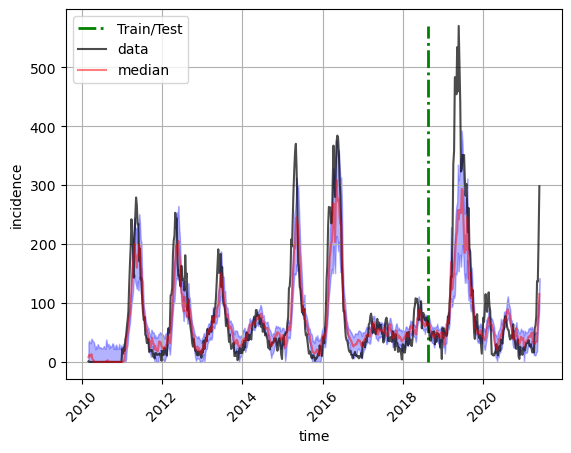

CPU times: user 2min 52s, sys: 12.8 s, total: 3min 5s
Wall time: 2min 35s


In [5]:
%%time

model = build_model(hidden = HIDDEN, features = FEAT, predict_n = PREDICT_N, look_back=LOOK_BACK, batch_size=1, loss = 'msle')

metrics_msle, hist_msle, m_train, m_val = make_pred(model, CITY, doenca = 'dengue', epochs = EPOCHS, end_train_date = None, 
                    ratio= 0.75, end_date = END_DATE,
                     predict_n = PREDICT_N, look_back =  LOOK_BACK, label = 'msle', filename = FILENAME_DATA)

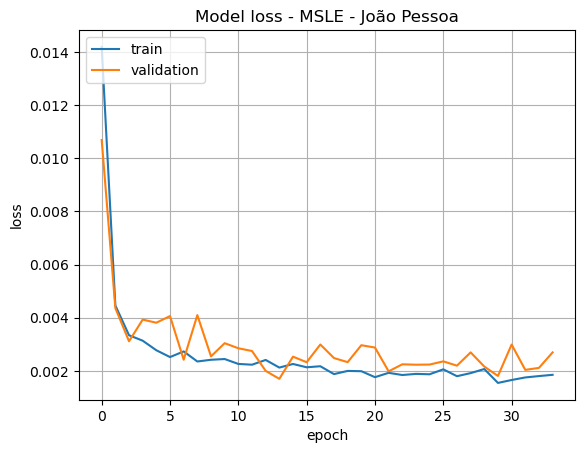

In [6]:
plot_loss(hist_msle, title = 'Model loss - MSLE - João Pessoa')

To specialize our lstm dengue model to predict better the peak of cases we propose a custom loss function. This function gives a weight of 10 to the predictions of ascending cases in the train data. 

This weight is given to the observations in the training data, where the fourth value is bigger than the second value of the target data. (Remember it is an array of length four since we forecast the next 4 observations).  

This functions is defined as: 

```
def custom_loss_msle(p = 1):
    """
    :param p: 
    """
    
    def my_loss_msle(y_true, y_pred):
        """
        :param y_true:
        :param y_pred: 
        """

        def f1(): 
            
            loss = tf.math.log(tf.math.add(y_true, 1)/ tf.math.add(y_pred, 1))
    
            loss = tf.square(loss)
        
            return tf.multiply(loss, p) 
        
        def f2(): 
            
            loss = tf.math.log(tf.math.add(y_true, 1)/ tf.math.add(y_pred, 1))
    
            loss = tf.square(loss)
        
            return loss

        msle = tf.cond(tf.less(tf.gather(y_true, 0)[1],tf.gather(y_true, 0)[3]) , 
                                     true_fn = f1,
                                     false_fn = f2 )

        return tf.reduce_mean(msle) 
    
    return my_loss_msle 
```

Let's train the model with a custom loss function:

Compilation Time :  0.001955747604370117
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4, 81)]           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 4, 8)             5760      
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 4, 8)              0         
                                                                 
 lstm_1 (LSTM)               (None, 8)                 544       
                                                                 
 dropout_2 (Dropout)         (None, 8)                

374/374 [==============================] - 1s 4ms/step - loss: 0.0081 - accuracy: 0.2647 - mape: 2658903.0000 - mse: 0.0041 - val_loss: 0.0128 - val_accuracy: 0.2836 - val_mape: 434595.0000 - val_mse: 0.0064
Epoch 32/400
374/374 [==============================] - 1s 4ms/step - loss: 0.0102 - accuracy: 0.2540 - mape: 2910936.2500 - mse: 0.0049 - val_loss: 0.0076 - val_accuracy: 0.2537 - val_mape: 895479.8125 - val_mse: 0.0039
Epoch 33/400
374/374 [==============================] - 1s 4ms/step - loss: 0.0115 - accuracy: 0.2701 - mape: 2553842.7500 - mse: 0.0048 - val_loss: 0.0100 - val_accuracy: 0.2388 - val_mape: 2242357.7500 - val_mse: 0.0050
Epoch 34/400
374/374 [==============================] - 1s 3ms/step - loss: 0.0093 - accuracy: 0.2674 - mape: 3081796.7500 - mse: 0.0044 - val_loss: 0.0108 - val_accuracy: 0.2239 - val_mape: 2607286.7500 - val_mse: 0.0052
Epoch 35/400
374/374 [==============================] - 1s 4ms/step - loss: 0.0078 - accuracy: 0.2567 - mape: 2577640.5000 - ms

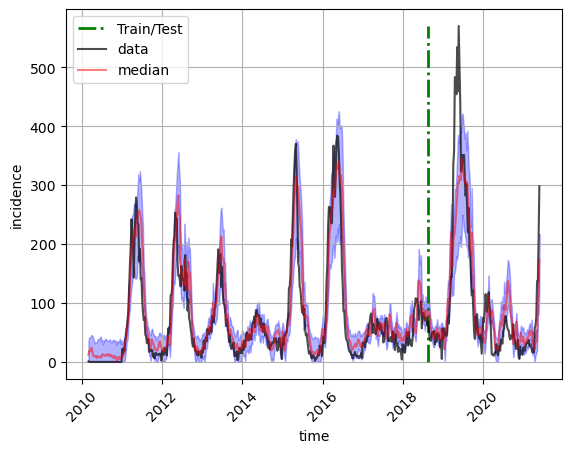

In [7]:
from lstm import custom_loss_msle

model = build_model(hidden = HIDDEN, features = FEAT, predict_n = PREDICT_N, look_back=LOOK_BACK, batch_size=1, loss = custom_loss_msle(p=10))

metrics_c_msle, hist_c_msle, m_c_train, m_c_val = make_pred(model, CITY, doenca = 'dengue', epochs = EPOCHS, end_train_date = None, 
                    ratio= 0.75, end_date = END_DATE,
                     predict_n = PREDICT_N, look_back =  LOOK_BACK, label = 'custom_msle', filename = FILENAME_DATA)

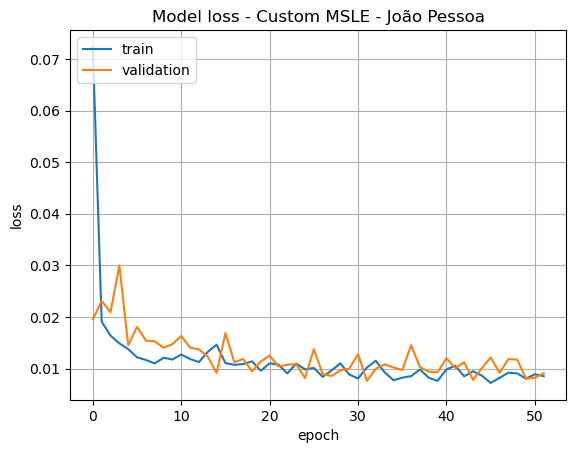

In [8]:
plot_loss(hist_c_msle, title = 'Model loss - Custom MSLE - João Pessoa')

Comparing the performance of the strategies:

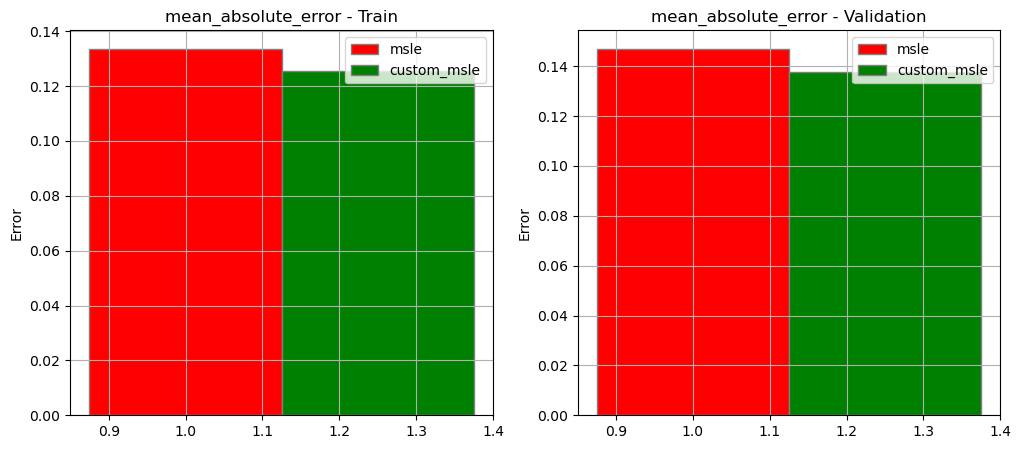

In [9]:
plot_comp(m_train, m_c_train,m_val, m_c_val, metric = 'mean_absolute_error')

Now, let's retrain the models with all the data available to apply the transfer learning step later:

Compilation Time :  0.0022258758544921875
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 4, 81)]           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 4, 8)             5760      
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 4, 8)              0         
                                                                 
 lstm_1 (LSTM)               (None, 8)                 544       
                                                                 
 dropout_2 (Dropout)         (None, 8)               

498/498 [==============================] - 2s 4ms/step - loss: 0.0022 - accuracy: 0.3775 - mape: 832771.5625 - mse: 0.0040 - val_loss: 0.0024 - val_accuracy: 0.4382 - val_mape: 674682.6250 - val_mse: 0.0041
Epoch 32/400
498/498 [==============================] - 2s 4ms/step - loss: 0.0024 - accuracy: 0.3394 - mape: 840091.6250 - mse: 0.0046 - val_loss: 0.0023 - val_accuracy: 0.3933 - val_mape: 58029.2344 - val_mse: 0.0038
Epoch 33/400
498/498 [==============================] - 2s 4ms/step - loss: 0.0022 - accuracy: 0.4116 - mape: 1175687.6250 - mse: 0.0040 - val_loss: 0.0030 - val_accuracy: 0.4157 - val_mape: 309520.2188 - val_mse: 0.0055
Epoch 34/400
498/498 [==============================] - 2s 4ms/step - loss: 0.0019 - accuracy: 0.3916 - mape: 561020.8125 - mse: 0.0034 - val_loss: 0.0035 - val_accuracy: 0.3596 - val_mape: 57.1774 - val_mse: 0.0069
Epoch 35/400
498/498 [==============================] - 2s 4ms/step - loss: 0.0023 - accuracy: 0.3655 - mape: 652133.8125 - mse: 0.0043 -

498/498 [==============================] - 3s 5ms/step - loss: 0.0022 - accuracy: 0.4337 - mape: 460482.0312 - mse: 0.0042 - val_loss: 0.0023 - val_accuracy: 0.4607 - val_mape: 163014.0625 - val_mse: 0.0038
Epoch 69/400
498/498 [==============================] - 3s 6ms/step - loss: 0.0019 - accuracy: 0.4237 - mape: 404201.8750 - mse: 0.0034 - val_loss: 0.0026 - val_accuracy: 0.4270 - val_mape: 491369.1562 - val_mse: 0.0052
Epoch 70/400
498/498 [==============================] - 3s 5ms/step - loss: 0.0018 - accuracy: 0.4438 - mape: 321864.1250 - mse: 0.0033 - val_loss: 0.0023 - val_accuracy: 0.4607 - val_mape: 379616.8438 - val_mse: 0.0037
Epoch 71/400
498/498 [==============================] - 3s 6ms/step - loss: 0.0018 - accuracy: 0.4498 - mape: 815639.5625 - mse: 0.0032 - val_loss: 0.0024 - val_accuracy: 0.4045 - val_mape: 447008.5000 - val_mse: 0.0045
Epoch 72/400
498/498 [==============================] - 3s 5ms/step - loss: 0.0016 - accuracy: 0.4398 - mape: 424073.0625 - mse: 0.00

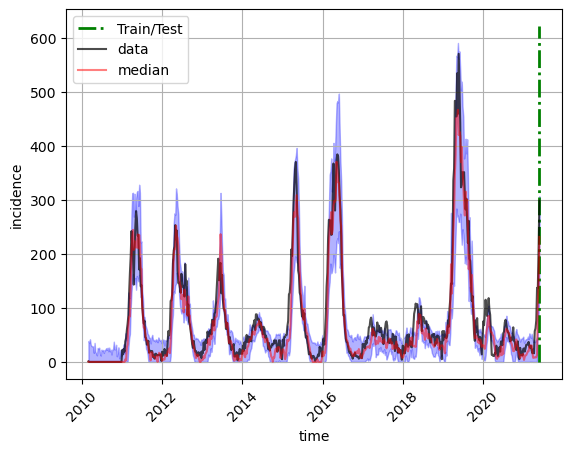

In [10]:
model = build_model(hidden = HIDDEN, features = FEAT, predict_n = PREDICT_N, look_back=LOOK_BACK, batch_size=1, loss = 'msle')

m_msle_all, h_msle_all, m_train_all, m_val_all = make_pred(model, CITY, doenca = 'dengue', epochs = EPOCHS, end_train_date = None, 
                    ratio= 1.0, end_date = END_DATE,
                     predict_n = PREDICT_N, look_back =  LOOK_BACK, label = 'msle_all',  filename = FILENAME_DATA)

Compilation Time :  0.002089977264404297
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 4, 81)]           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 4, 8)             5760      
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 4, 8)              0         
                                                                 
 lstm_1 (LSTM)               (None, 8)                 544       
                                                                 
 dropout_2 (Dropout)         (None, 8)                

498/498 [==============================] - 2s 4ms/step - loss: 0.0113 - accuracy: 0.2751 - mape: 1911488.2500 - mse: 0.0058 - val_loss: 0.0118 - val_accuracy: 0.2921 - val_mape: 1020114.8125 - val_mse: 0.0039
Epoch 32/400
498/498 [==============================] - 2s 3ms/step - loss: 0.0117 - accuracy: 0.2691 - mape: 1444440.6250 - mse: 0.0053 - val_loss: 0.0112 - val_accuracy: 0.3146 - val_mape: 754293.5625 - val_mse: 0.0041
Epoch 33/400
498/498 [==============================] - 2s 3ms/step - loss: 0.0100 - accuracy: 0.2731 - mape: 1903600.2500 - mse: 0.0051 - val_loss: 0.0143 - val_accuracy: 0.2809 - val_mape: 1016901.1875 - val_mse: 0.0040
Epoch 34/400
498/498 [==============================] - 2s 3ms/step - loss: 0.0124 - accuracy: 0.2610 - mape: 1842275.2500 - mse: 0.0055 - val_loss: 0.0161 - val_accuracy: 0.3146 - val_mape: 1483807.8750 - val_mse: 0.0052
Epoch 35/400
498/498 [==============================] - 2s 4ms/step - loss: 0.0118 - accuracy: 0.2631 - mape: 2288251.0000 - m

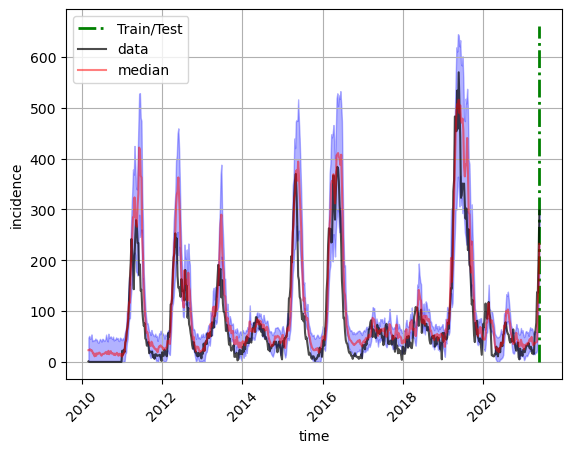

In [11]:
model = build_model(hidden = HIDDEN, features = FEAT, predict_n = PREDICT_N, look_back=LOOK_BACK, batch_size=1, loss = custom_loss_msle(p=10))

m_c_msle_all, h_c_msle_all, m_c_train_all, m_c_val_all = make_pred(model, CITY, doenca = 'dengue', epochs = EPOCHS, end_train_date = None, 
                    ratio= 1.0, end_date = END_DATE,
                     predict_n = PREDICT_N, look_back =  LOOK_BACK, label = 'custom_msle_all',  filename = FILENAME_DATA)

PGBM model

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Estimator 0/100, Train metric: 72.8972
Estimator 1/100, Train metric: 66.3975
Estimator 2/100, Train metric: 60.5059
Estimator 3/100, Train metric: 55.1346
Estimator 4/100, Train metric: 50.2513
Estimator 5/100, Train metric: 45.8585
Estimator 6/100, Train metric: 41.8335
Estimator 7/100, Train metric: 38.1909
Estimator 8/100, Train metric: 34.8878
Estimator 9/100, Train metric: 31.9342
Estimator 10/100, Train metric: 29.2342
Estimator 11/100, Train metric: 26.7888
Estimator 12/100, Train metric: 24.5816
Estimator 13/100, Train metric: 22.5565
Estimator 14/100, Train metric: 20.7025
Estimator 15/100, Train metric: 19.0625
Estimator 16/100, Train metric: 17.5247
Estimator 17/100, Train metric: 16.1544
Estimator 18/100, Train metric: 14.9104
Estimator 19/100, Train metric: 13.7393
Estimator 20/100, Train metric: 12.7111
Estimator 21/100, Train metric: 11.7518
Estimator 22/100, Train metric: 10.8809
Estimator 23/100, Train metric: 10.0894
Estimator 24/100, Train metric: 9.3772
Estimator 2

Estimator 10/100, Train metric: 30.5980
Estimator 11/100, Train metric: 28.1399
Estimator 12/100, Train metric: 25.9186
Estimator 13/100, Train metric: 23.8958
Estimator 14/100, Train metric: 22.0897
Estimator 15/100, Train metric: 20.3871
Estimator 16/100, Train metric: 18.8380
Estimator 17/100, Train metric: 17.4551
Estimator 18/100, Train metric: 16.1732
Estimator 19/100, Train metric: 14.9903
Estimator 20/100, Train metric: 13.9779
Estimator 21/100, Train metric: 13.0300
Estimator 22/100, Train metric: 12.1757
Estimator 23/100, Train metric: 11.4202
Estimator 24/100, Train metric: 10.6860
Estimator 25/100, Train metric: 10.0370
Estimator 26/100, Train metric: 9.4488
Estimator 27/100, Train metric: 8.9130
Estimator 28/100, Train metric: 8.4364
Estimator 29/100, Train metric: 7.9715
Estimator 30/100, Train metric: 7.5766
Estimator 31/100, Train metric: 7.2241
Estimator 32/100, Train metric: 6.8708
Estimator 33/100, Train metric: 6.5701
Estimator 34/100, Train metric: 6.2792
Estimator

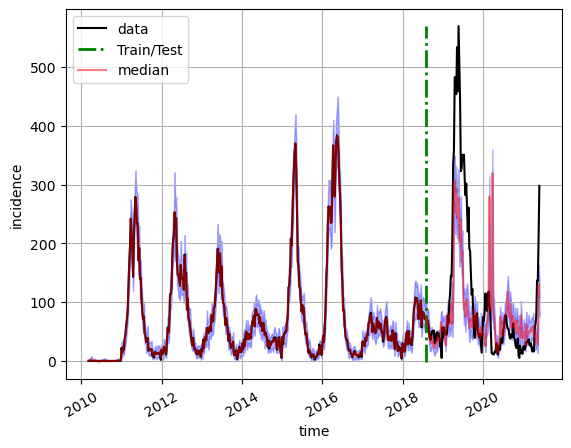

In [12]:

preds, preds25, preds975, X_train, targets = pgbm_pred(CITY, STATE, predict_n = PREDICT_N, look_back = LOOK_BACK,
                                                           doenca = 'dengue', ratio = 0.75, ini_date = None,
                                                           end_date = END_DATE, label = 'train_test',  filename = FILENAME_DATA)

Estimator 0/100, Train metric: 86.3786
Estimator 1/100, Train metric: 78.7715
Estimator 2/100, Train metric: 71.8679
Estimator 3/100, Train metric: 65.5968
Estimator 4/100, Train metric: 59.9141
Estimator 5/100, Train metric: 54.7624
Estimator 6/100, Train metric: 50.1081
Estimator 7/100, Train metric: 45.8692
Estimator 8/100, Train metric: 42.0600
Estimator 9/100, Train metric: 38.5745
Estimator 10/100, Train metric: 35.4249
Estimator 11/100, Train metric: 32.5546
Estimator 12/100, Train metric: 29.9400
Estimator 13/100, Train metric: 27.6138
Estimator 14/100, Train metric: 25.4938
Estimator 15/100, Train metric: 23.5723
Estimator 16/100, Train metric: 21.8394
Estimator 17/100, Train metric: 20.2635
Estimator 18/100, Train metric: 18.8521
Estimator 19/100, Train metric: 17.5935
Estimator 20/100, Train metric: 16.4166
Estimator 21/100, Train metric: 15.3422
Estimator 22/100, Train metric: 14.3877
Estimator 23/100, Train metric: 13.4952
Estimator 24/100, Train metric: 12.6949
Estimator 

Estimator 10/100, Train metric: 37.2597
Estimator 11/100, Train metric: 34.4459
Estimator 12/100, Train metric: 31.9486
Estimator 13/100, Train metric: 29.6757
Estimator 14/100, Train metric: 27.6213
Estimator 15/100, Train metric: 25.7238
Estimator 16/100, Train metric: 24.0072
Estimator 17/100, Train metric: 22.4275
Estimator 18/100, Train metric: 21.0383
Estimator 19/100, Train metric: 19.8375
Estimator 20/100, Train metric: 18.6924
Estimator 21/100, Train metric: 17.6680
Estimator 22/100, Train metric: 16.7597
Estimator 23/100, Train metric: 15.8761
Estimator 24/100, Train metric: 15.0562
Estimator 25/100, Train metric: 14.3158
Estimator 26/100, Train metric: 13.6545
Estimator 27/100, Train metric: 12.9938
Estimator 28/100, Train metric: 12.4399
Estimator 29/100, Train metric: 11.9333
Estimator 30/100, Train metric: 11.4833
Estimator 31/100, Train metric: 11.0562
Estimator 32/100, Train metric: 10.6495
Estimator 33/100, Train metric: 10.2994
Estimator 34/100, Train metric: 9.9312
E

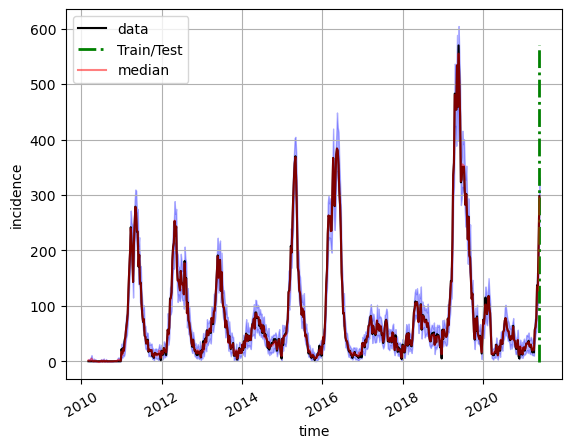

In [13]:
preds, preds25, preds975, X_train, targets = pgbm_pred(CITY, STATE, PREDICT_N, LOOK_BACK, doenca = 'dengue', ini_date = None, end_train_date = END_DATE, end_date = END_DATE,  filename = FILENAME_DATA)
   